In [1]:
from jesse import helpers, research

START = "2022-08-01"
END = "2025-12-20"

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp(START),
    helpers.date_to_timestamp(END),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)
candles = candles[candles[:, 5] > 0]

candles.shape

/opt/homebrew/Caskroom/miniforge/base/envs/jesse/lib/python3.12/site-packages/jesse/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


(1781222, 6)

(38467, 6)


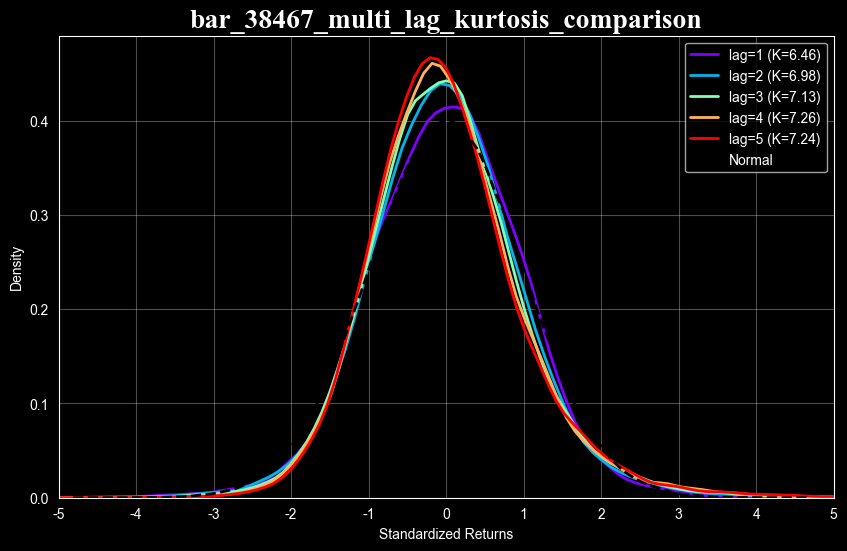

In [8]:
from src.bars.fusion.demo import DemoBar
from research.plot import plot_kde

bar_container = DemoBar(clip_r=0.004, threshold=1.399)
bar_container.update_with_candles(candles)
fusion_bar = bar_container.get_fusion_bars()
print(fusion_bar.shape)

plot_kde(fusion_bar[:, 2], lag=5, sign_shift=-1)

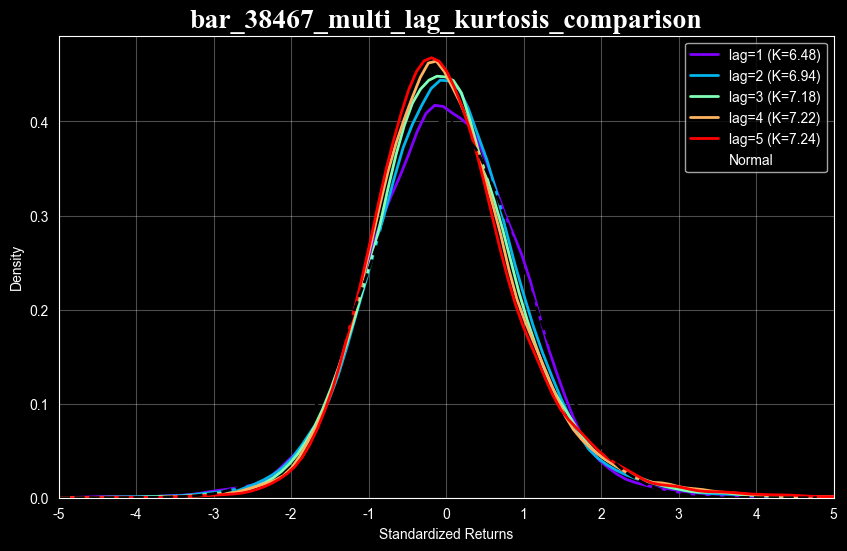

In [9]:
plot_kde(fusion_bar[:, 2], lag=5, sign_shift=1)

In [7]:
import numpy as np

thres = bar_container.get_thresholds(candles)
np.quantile(thres, 0.5)

0.006319988935658502

In [48]:
import arrow

36169 / (arrow.get(END) - arrow.get(START)).days / 24

1.2124229015821937

In [4]:
from pprint import pprint
from research.hurst_adf_kpss.trend_analyzer import quick_trend_check

"""
DemoBar备选threshold:
5.8085
1.4535
1.399
2.095
"""

for window in [20, 40, 60]:
    pprint(quick_trend_check(fusion_bar, window=window))
    print("-" * 60)

(0.6869760776485303,
 '【强趋势且非平稳-适合趋势策略】\n'
 '  Hurst=0.687(强趋势持续性)\n'
 '  ADF检验[H0:存在单位根(非平稳)]: p=0.4041, 无法拒绝原假设→序列非平稳; KPSS检验[H0:序列平稳]: p=0.0321, '
 '拒绝原假设→序列非平稳\n'
 '  综合结论: 三重确认趋势特征，价格持续偏离均值，适合趋势跟踪',
 5)
------------------------------------------------------------
(0.640152275762248,
 '【矛盾-需进一步验证】\n'
 '  Hurst=0.640(强趋势持续性)\n'
 '  ADF检验[H0:存在单位根(非平稳)]: p=0.2151, 无法拒绝原假设→序列非平稳; KPSS检验[H0:序列平稳]: p=0.1000, '
 '无法拒绝原假设→序列平稳 (警告:p值可能更大)\n'
 '  ⚠️ 矛盾分析: ADF认为非平稳但KPSS认为平稳（两个检验结论相反）\n'
 '  可能原因: (1)序列处于临界状态 (2)窗口大小不当 (3)统计功效不足\n'
 '  建议: 结合Hurst(0.640)倾向于有趋势性，但需谨慎对待，建议降低仓位或尝试不同窗口',
 3)
------------------------------------------------------------
(0.5610750590430461,
 '【强趋势且非平稳-适合趋势策略】\n'
 '  Hurst=0.561(趋势持续性)\n'
 '  ADF检验[H0:存在单位根(非平稳)]: p=0.1297, 无法拒绝原假设→序列非平稳; KPSS检验[H0:序列平稳]: p=0.0167, '
 '拒绝原假设→序列非平稳\n'
 '  综合结论: 三重确认趋势特征，价格持续偏离均值，适合趋势跟踪',
 4)
------------------------------------------------------------


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
size = 0.2     ##############  初始成交额变化量  ####################

add_size = 10000     ##############  每次累加的成交额变化量  ####################

baseline = "M99_1m_X_"       ############### 保存文件的前缀 ##################


for j in range(1):        ############# 循环次数 ############   
    
    
    file_name ='M99_1m_2010.1.1_2025.1.31.csv'       ###############  原始数据文件 ############
    df = pd.read_csv(file_name)


    buf_o = []
    buf_h = []
    buf_l = []
    buf_c = []
    buf_v = []
    buf_pos1 = []
    buf_pos2 = []
    res = []

    pos_sum = 0


    for i in range(1,len(df)):
        
        p_t = df['datetime'].iloc[i]
        p_o = df['open'].iloc[i]
        p_h = df['high'].iloc[i]
        p_l = df['low'].iloc[i]
        p_c = df['close'].iloc[i]
        p_c2 = df['close'].iloc[i-1]
        p_v = df['volume'].iloc[i]    
        p_oi = df['open_interest'].iloc[i]
        p_tt = df['total_turnover'].iloc[i]


        di = df.index.values[i]


        buf_o.append(p_o)
        buf_h.append(p_h)
        buf_l.append(p_l)
        buf_c.append(p_c)
        buf_v.append(p_v)
        
        pos_sum = pos_sum + (abs(p_c - p_c2) * (p_h - p_l) / p_c)   

        if pos_sum >= size:
            o = buf_o[0]
            h = max(buf_h)
            l = min(buf_l)
            c = buf_c[-1]
            v = sum(buf_v)
            p = pos_sum

            

            res.append({
                'eob': p_t,
                'open': o,
                'high': h,
                'low': l,
                'close': c,  
                'volume': v,
                'pos': p,
                'hang':di
            })

            buf_o = []
            buf_h = []
            buf_l = []
            buf_c = []
            buf_v = []
            pos_sum = 0


    


    aaa = pd.DataFrame(res)
    date = aaa['eob'] > '2023-01-01'   #### 测试集数量
    
    aaa.to_csv('./temp/' + baseline + str(size) + "_" + str(len(aaa)) + "_" +  str(len(aaa[date])) + ".csv",index = False)


    title_file = baseline + str(size) + "_" + str(len(aaa)) + "_" +  str(len(aaa[date]))
    file_name1 = './temp/' + baseline + str(size) + "_" + str(len(aaa)) + "_" +  str(len(aaa[date])) + ".csv"
    bars = pd.read_csv(file_name1)

    size = size + add_size   ######## 累加  ######


    bars.set_index("eob", inplace=True)

    returns_1 = np.log(bars['close']).diff().dropna()
    returns_2 = np.log(bars['close']).diff(periods=2).dropna()
    returns_3 = np.log(bars['close']).diff(periods=3).dropna()
    returns_4 = np.log(bars['close']).diff(periods=4).dropna()
    returns_5 = np.log(bars['close']).diff(periods=5).dropna()
    

    standard_1 = (returns_1 - returns_1.mean()) / returns_1.std()
    standard_2 = (returns_2 - returns_2.mean()) / returns_2.std()
    standard_3 = (returns_3 - returns_3.mean()) / returns_3.std()
    standard_4 = (returns_4 - returns_4.mean()) / returns_4.std()
    standard_5 = (returns_5 - returns_5.mean()) / returns_5.std()
   

    plt.figure(figsize=(16,12))


    sns.kdeplot(standard_1, label="1", color='darkred')
    sns.kdeplot(standard_2, label="2", color='green')
    sns.kdeplot(standard_3, label="3", color='blue')
    sns.kdeplot(standard_4, label="4", color='orange')
    sns.kdeplot(standard_5, label="5", color='magenta')


    sns.kdeplot(np.random.normal(size=1000000), label="Normal", color='black', linestyle="--")

    plt.xticks(range(-5, 6))
    plt.legend(loc=8, ncol=5)
    plt.title(title_file,loc='center', fontsize=20, fontweight="bold", fontname="Times New Roman")
    plt.xlim(-5, 5)
    plt.grid(1)
    # plt.show()

    plt.savefig(file_name1 + ".jpg")
    plt.close()